In [ ]:
from dataset_test import METRLADatasetLoader;

In [32]:
import os
import urllib
import zipfile
import numpy as np
import torch
import ssl
from torch_geometric.utils import dense_to_sparse
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
class METRLADatasetLoader(object):
    """A traffic forecasting dataset based on Los Angeles
    Metropolitan traffic conditions. The dataset contains traffic
    readings collected from 207 loop detectors on highways in Los Angeles
    County in aggregated 5 minute intervals for 4 months between March 2012
    to June 2012.

    For further details on the version of the sensor network and
    discretization see: `"Diffusion Convolutional Recurrent Neural Network:
    Data-Driven Traffic Forecasting" <https://arxiv.org/abs/1707.01926>`_
    """

    def __init__(self, raw_data_dir=os.path.join(os.getcwd(), "data")):
        super(METRLADatasetLoader, self).__init__()
        self.raw_data_dir = raw_data_dir
        self._read_web_data()

    def _download_url(self, url, save_path):  # pragma: no cover
        ctx = ssl.create_default_context();
        ctx.check_hostname = False;
        ctx.verify_mode = ssl.CERT_NONE;
        with urllib.request.urlopen(url, context=ctx) as dl_file:
            with open(save_path, "wb") as out_file:
                out_file.write(dl_file.read())

    def _read_web_data(self):
        # url = "https://graphmining.ai/temporal_datasets/METR-LA.zip"

        # # Check if zip file is in data folder from working directory, otherwise download
        # if not os.path.isfile(
        #     os.path.join(self.raw_data_dir, "METR-LA.zip")
        # ):  # pragma: no cover
        #     if not os.path.exists(self.raw_data_dir):
        #         os.makedirs(self.raw_data_dir)
        #     self._download_url(url, os.path.join(self.raw_data_dir, "METR-LA.zip"))

        # if not os.path.isfile(
        #     os.path.join(self.raw_data_dir, "adj_mat.npy")
        # ) or not os.path.isfile(
        #     os.path.join(self.raw_data_dir, "node_values.npy")
        # ):  # pragma: no cover
        #     with zipfile.ZipFile(
        #         os.path.join(self.raw_data_dir, "METR-LA.zip"), "r"
        #     ) as zip_fh:
        #         zip_fh.extractall(self.raw_data_dir)


        A = np.load(os.path.join(self.raw_data_dir, "adj_mat.npy"))
        X = np.load(os.path.join(self.raw_data_dir, "node_values.npy")).transpose(
            (1, 2, 0)
        )
#         print(X.size);
        X = X.astype(np.float32)

        # Normalise as in DCRNN paper (via Z-Score Method)
        means = np.mean(X, axis=(0, 2))
        X = X - means.reshape(1, -1, 1)
        stds = np.std(X, axis=(0, 2))
        X = X / stds.reshape(1, -1, 1)

        self.A = torch.from_numpy(A)
        self.X = torch.from_numpy(X)

    def _get_edges_and_weights(self):
        edge_indices, values = dense_to_sparse(self.A)
        edge_indices = edge_indices.numpy()
        values = values.numpy()
        self.edges = edge_indices
        self.edge_weights = values

    def _generate_task(self, num_timesteps_in: int = 12, num_timesteps_out: int = 12):
        """Uses the node features of the graph and generates a feature/target
        relationship of the shape
        (num_nodes, num_node_features, num_timesteps_in) -> (num_nodes, num_timesteps_out)
        predicting the average traffic speed using num_timesteps_in to predict the
        traffic conditions in the next num_timesteps_out

        Args:
            num_timesteps_in (int): number of timesteps the sequence model sees
            num_timesteps_out (int): number of timesteps the sequence model has to predict
        """
        indices = [
            (i, i + (num_timesteps_in + num_timesteps_out))
            for i in range(self.X.shape[2] - (num_timesteps_in + num_timesteps_out) + 1)
        ]

        # Generate observations
        features, target = [], []
        for i, j in indices:
            features.append((self.X[:, :, i : i + num_timesteps_in]).numpy())
            target.append((self.X[:, :, i + num_timesteps_in : j]).numpy())

        self.features = features
        self.targets = target

    def get_dataset(
        self, num_timesteps_in: int = 12, num_timesteps_out: int = 12
    ) -> StaticGraphTemporalSignal:
        """Returns data iterator for METR-LA dataset as an instance of the
        static graph temporal signal class.

        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The METR-LA traffic
                forecasting dataset.
        """
        self._get_edges_and_weights()
        self._generate_task(num_timesteps_in, num_timesteps_out)
        dataset = StaticGraphTemporalSignal(
            self.edges, self.edge_weights, self.features, self.targets
        )

        return dataset

In [33]:
loader = METRLADatasetLoader();

dataset = loader.get_dataset();

from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

import random
import gc

In [34]:

print(train_dataset[0])

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 2, 12])


In [35]:
train_dataset[12].x[0]

tensor([[ 0.3724,  0.2452,  0.4961,  0.6521,  0.1126,  0.5311,  0.5091,  0.4713,
          0.4218,  0.3909,  0.4761,  0.5641],
        [-1.5846, -1.5725, -1.5605, -1.5484, -1.5364, -1.5243, -1.5123, -1.5002,
         -1.4882, -1.4761, -1.4641, -1.4520]])

In [36]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods,
                           improved=True)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h;

# GPU support
device = torch.device('cpu') # cuda
subset = 500
# gc.collect() # garbage collector
# torch.cuda.empty_cache() # cuda

In [37]:
model_speed = TemporalGNN(node_features=2, periods=12).to(device)
model_density = TemporalGNN(node_features=2, periods=12).to(device)
optimizer_speed = torch.optim.Adam(model_speed.parameters(), lr=0.01)
optimizer_density = torch.optim.Adam(model_density.parameters(), lr=0.01)
model_speed.train()
model_density.train()

print("Running training...")
for epoch in range(20):
    loss_speed = 0
    loss_density = 0
    for step in range(subset):
        snapshot = train_dataset[(epoch * subset) + step].to(device) # shift snapshot subset every epoch
        # snapshot = train_dataset[random.randrange(train_dataset.snapshot_count)].to(device) # random snapshot
        # Get model predictions
        y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
        y_hat_density = model_density(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
        loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)

    loss_speed = loss_speed / (step + 1)
    loss_density = loss_density / (step + 1)
    loss_speed.backward()
    loss_density.backward()
    optimizer_speed.step()
    optimizer_speed.zero_grad()
    optimizer_density.step()
    optimizer_density.zero_grad()
    print("Epoch speed {} train MSE: {:.4f}".format(epoch, loss_speed.item()))
    print("Epoch density {} train MSE: {:.4f}".format(epoch, loss_density.item()))

# gc.collect()
# torch.cuda.empty_cache()

Running training...
Epoch speed 0 train MSE: 0.8109
Epoch density 0 train MSE: 0.8418
Epoch speed 1 train MSE: 0.4835
Epoch density 1 train MSE: 1.0727
Epoch speed 2 train MSE: 0.6825
Epoch density 2 train MSE: 1.0815
Epoch speed 3 train MSE: 0.9632
Epoch density 3 train MSE: 0.8386
Epoch speed 4 train MSE: 2.0102
Epoch density 4 train MSE: 0.7767
Epoch speed 5 train MSE: 0.7046
Epoch density 5 train MSE: 0.9120
Epoch speed 6 train MSE: 0.5481
Epoch density 6 train MSE: 0.8399
Epoch speed 7 train MSE: 0.5992
Epoch density 7 train MSE: 0.5461
Epoch speed 8 train MSE: 0.5322
Epoch density 8 train MSE: 0.6002
Epoch speed 9 train MSE: 0.3189
Epoch density 9 train MSE: 0.6090
Epoch speed 10 train MSE: 0.2688
Epoch density 10 train MSE: 0.5262
Epoch speed 11 train MSE: 0.7054
Epoch density 11 train MSE: 0.2757
Epoch speed 12 train MSE: 1.2970
Epoch density 12 train MSE: 0.4298
Epoch speed 13 train MSE: 0.3076
Epoch density 13 train MSE: 0.4142
Epoch speed 14 train MSE: 1.6580
Epoch density 1

In [38]:
model_speed.eval()
model_density.eval()
loss_speed = 0
loss_density = 0
horizon = 288

# Store for analysis
predictions_speed = []
labels_speed = []
predictions_density = []
labels_density = []
anomalies_speed = [test_dataset[i].y.permute(1, 0, 2)[0] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph
anomalies_density = [test_dataset[i].y.permute(1, 0, 2)[1] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph

for step in range(horizon):
    snapshot = test_dataset[step].to(device)
    # Get predictions
    y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
    y_hat_density = model_density(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
    loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)
    if step > 1:
        # acceleration or deviation
        acc_speed = torch.mean(abs((y_hat_speed - predictions_speed[-1]) / predictions_speed[-1]))
        if acc_speed > 1: # random value for now
            anomalies_speed[step] = y_hat_speed # mark point on predicted graph if it exceeds some threshold of acceleration
        acc_density = torch.mean(abs((y_hat_density - predictions_density[-1]) / predictions_density[-1]))
        if acc_density > 1: # random value for now
            anomalies_density[step] = y_hat_density # mark point on predicted graph if it exceeds some threshold of acceleration
    labels_speed.append(snapshot.y.permute(1, 0, 2)[0])
    labels_density.append(snapshot.y.permute(1, 0, 2)[1])
    predictions_speed.append(y_hat_speed)
    predictions_density.append(y_hat_density)

loss_speed = loss_speed / (step+1)
loss_speed = loss_speed.item()
loss_density = loss_density / (step+1)
loss_density = loss_density.item()

print("Test speed MSE: {:.4f}".format(loss_speed))
print("Test density MSE: {:.4f}".format(loss_density))

# gc.collect()
# torch.cuda.empty_cache()

Test speed MSE: 0.6893
Test density MSE: 0.3369


In [39]:
y_hat_speed.shape

torch.Size([207, 12])

In [40]:
import numpy as np

sensor = 200
timestep = 11
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_speed])
labs  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_speed])
anoms = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_speed])
preds1 = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_density])
labs1  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_density])
anoms1 = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_density])

<Axes: >

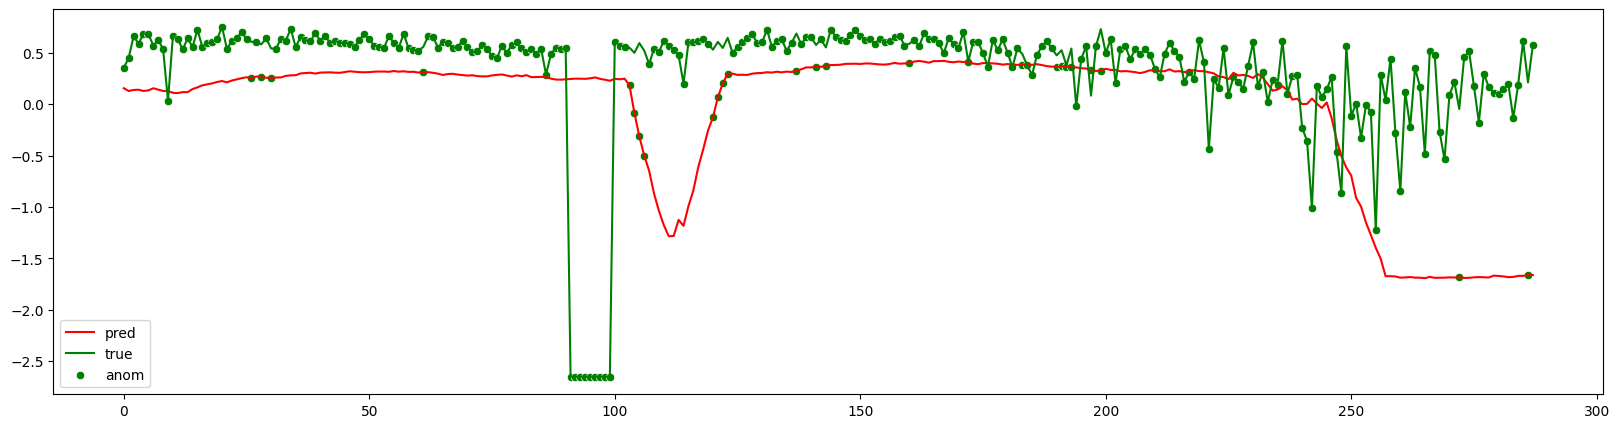

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred", color='red')
sns.lineplot(data=labs, label="true", color='green')
sns.scatterplot(data=anoms, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

<Axes: >

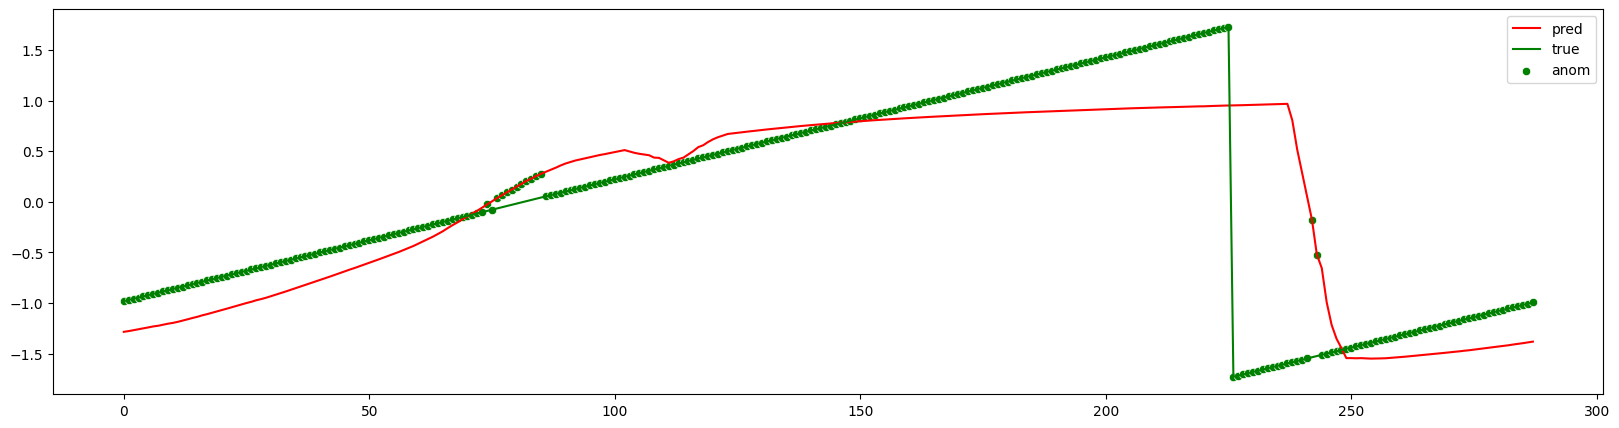

In [42]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds1, label="pred", color='red')
sns.lineplot(data=labs1, label="true", color='green')

sns.scatterplot(data=anoms1, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 